# Data Project on ASL Classification

By Dexter Friis-Hecht

For my classification project, I'll be working with an [ASL Alphabet](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) dataset, provided by user [Akash](https://www.kaggle.com/grassknoted) on Kaggle. The dataset features 3000 examples of the ASL sign for each letter in the alphabet, as well as the additional classes "SPACE," "DELETE," and "NOTHING." In total, there are 87,000 200x200 images. To train the model within this notebook, please download the dataset from the hyperlink above, and place the data in the folder titled 'data.'

## Data Citation:

@misc{https://www.kaggle.com/grassknoted/aslalphabet_akash nagaraj_2018, \
title={ASL Alphabet}, \
url={https://www.kaggle.com/dsv/29550}, \
DOI={10.34740/KAGGLE/DSV/29550},

As a preliminary step prior to model implementation, the dataset will be loaded in:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split

## Load Dataset

In [2]:
DATA_PATH = 'data/asl_alphabet_train' # Path to image data

device = 'cuda' if torch.cuda.is_available() else 'cpu' # Make sure we're using cuda cores
print(device)

# Setup base image data. Mean and STD were calculated from a random sampling of the dataset
img_size = 200
mean = [0.5119, 0.5042, 0.5128]
std = [0.2499, 0.2398, 0.2451]

# Set up the two image pre-processing pipeline that'll be used
image_transforms = {
        "viz": transforms.Compose([
            transforms.Resize(size=img_size),
            transforms.CenterCrop(size=img_size),
            transforms.ToTensor()
        ]),

        "pre": transforms.Compose([
            transforms.Resize(size=img_size),
            transforms.CenterCrop(size=img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

}

dataset_viz = datasets.ImageFolder(
        root = DATA_PATH,
        transform = image_transforms["viz"]
)

idx_to_class = {v: k for k, v in dataset_viz.class_to_idx.items()} # Create a dictionary of all image indices and their ground truth label

cuda


For training the model, I'll be using a pretty simple pre-processing pipeline, as shown above. First, images are resized and cropped to be exactly 3x200x200 pixels. While all data from the ASL dataset meets this criteria, this ensures flexibility for testing additional data. The images are then converted to tensors and normalized. The values for mean and standard deviation were found by sampling a random selection of the dataset, and finding the average mean and standard deviation of the images. This should help the model be more resistant to variance in lighting, extreme differences in pixels, as well as reduce the size of weights within the model itself.

To get a feel for the range of images within the dataset, we create a plot of them below:

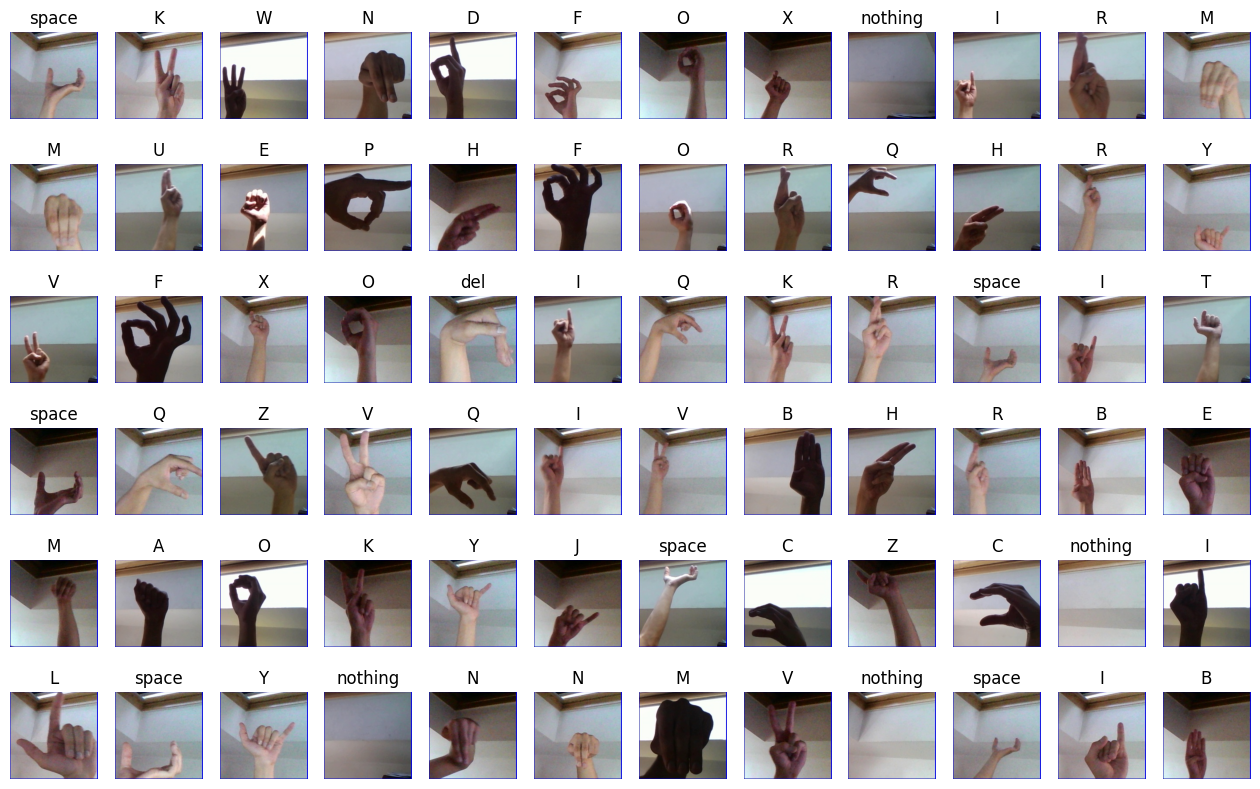

In [3]:
# Visualize the data within the model
figure = plt.figure(figsize=(16, 10))
cols, rows = 12, 6
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_viz), size=(1,)).item()
    img, label = dataset_viz[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(idx_to_class[label])
    plt.axis("off")
    img2 = img.permute(*torch.arange(img.ndim - 1, -1, -1))
    img2 = torch.rot90(img2, dims=[1,0])
    plt.imshow(img2.squeeze(), cmap="gray")
plt.show()

From a visual inspection of the dataset, there seems to be good variation in the size, translation, and lighting of the hand. Where the dataset could be lacking is in 3D rotation about the hand, skin tone, and background. For the initial model, I won't be augmenting the data due to the reasonable variation already present. However, for a real world application, there should be examples in different environments, and from different perspectives of the hand.

In [4]:
dataset = datasets.ImageFolder(
        root = DATA_PATH,
        transform = image_transforms["pre"]
)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

The dataset is now split into training, testing, and validation groups, with a 7-2-1 split. This ensures that while the majority of images are being used for training, we have a validation set to check model performance on unseen images mid-training, and then a final test group to evaluate the model after training. 

In [5]:
train_dataset, val_dataset, test_dataset = random_split(dataset, (0.7, 0.2, 0.1))
print(f"Length of Train Set: {len(train_dataset)}, Length of Validation Set: {len(val_dataset)}, Length of Test Set: {len(test_dataset)}")

Length of Train Set: 60900, Length of Validation Set: 17400, Length of Test Set: 8700


Each dataset is then split into batches. This will allow us to leverage the parallel nature of neural networks to train more efficiently. While training in batches does increase the chance of the model converging on a local minima instead of the global during training, the batch size (64) is relatively low compared to the size of the training set.

In [6]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=64, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=64)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=64)

dataloaders = {
    "train": train_loader,
    "validation": val_loader,
    "test": test_loader
}

# Applications

In the realm of accessibility, an algorithm capable of interpreting ASL is quiet relevant. The first use case that comes to mind would be ASL transcription with a computer vision system. For example, if someone was holding a speech in ASL, or there was a video conference with ASL, those words could be transcribed in the same way that audio is transcribed. It could also help with real-time conversations across languages, where a common written language is not shared. Finally, it can also be useful as an ASL teaching aid, where learnings can use it as real-time feedback for their signing capabilities.

In order for my model to be well-suited to the tasks above, it must be accurate to ensure quality of transcription, and it must have quick input inference so that it can keep up with a conversational pace. I'll consider my model generally accurate if it can attain an accuracy of 90% or above. However, it will still be critical to evaluate the model's False Positive and False Negative rates to confirm whether certain classes are being miss-classified often. 

For inference speed, ideally it should be able to keep up with a video input running at 30 fps. This metric can be a bit more difficult to evaluate, since this will vary with hardware. However, by comparing the training times as well as inference times between model iterations, I should be able to get a general idea for changes in model speed.

# Algorithm

For this project, I've chosen to implement a Convolutional Neural Network (CNN). This is for two main reasons:

1. Each image is 3x200x200 pixels due to the RGB channel. If I took a Multi-Layer Perceptron (MLP) approach to the model, this will result in 120,000 inputs per image, and would require an enormous amount of parameters per layer to process, bloating both model size and training time. Using a CNN will allow me to extract features from the images with a substantial reduction in total parameters needed.

2. Using a CNN provides a more intuitive method to extract the key features that distinguish each hand sign. By visually looking for the key attributes of each sign with convolution kernels, this aligns more closely to how people visually distinguish them. Additionally, the CNN architecture introduces some spatial invariance to the input images. Since we're looking for which portions of the image activate the kernels the most, the position of the hand in the image frame will have less of an influence on model outputs than what an MLP would produce.

However, this approach has a couple of key implications. The primary implication is the issues stemming from the diversity of training data. The all of the dataset images are in the same environment, from the same camera angle, and with the same skin tone. Similarly to facial recognition algorithms, the lack of different people signing in ASL could impact the model's ability to perform reliably under different circumstances. My hope is that since the "outline" of the hand changes quite a bit between signs, this issue might be less pronounced with ASL than it is with faces, but the lack of different people's hand's could still pose an issue. Additionally, since all the images are captured in the same style, this will probably harm the model's ability to generalize to varied signing environments.

Finally, this algorithm will have one pretty serious limitation for real world use. Within ASL, signs for individual letters are only a small fraction of the entire language. If you wished to properly transcribe ASL video, this algorithm would be wholly incapable of doing so. Additionally, a lot of ASL relies on movements, and not just static poses. In order to support that, this model would need to accept a fourth input dimension in order to support changes to the input over time. That is something of much higher complexity that simply isn't within the scope of this dataset.


# Implimentation

For my model, I've decide to take inspiration from [AlexNet](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf), an architecture first proposed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton in their landmark paper "ImageNet Classification with Deep Convolution Neural Networks." The model's architecture is shown below:

![AlexNet Architecture](images/AlexNetArch.png) \
*credit: AlexNet paper*

Since this model was built to classify 1.2 million images from the ImageNet dataset into 1000 classes, it will need modifications to work with my much smaller dataset of 87,000 images into 29 classes.

# First Iteration Model Architecture

In [7]:
class DexNet(nn.Module):
    def __init__(self, num_inputs):
        super().__init__()
        # Setup Convolutional Layers
        self.feature = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.neural = nn.Sequential(
            nn.Linear(256*num_inputs, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 29)
        )
    
    def forward(self, x):
        out = self.feature(x)
        out = out.view(out.size(0), -1)
        out = self.neural(out)
        return out

In [ ]:
model_sum = DexNet(num_inputs=64).to(device)
summary(model_sum, (3,200,200))

"""
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 256, 8, 8]           --
|    └─Conv2d: 2-1                       [-1, 96, 49, 49]          34,944
|    └─ReLU: 2-2                         [-1, 96, 49, 49]          --
|    └─MaxPool2d: 2-3                    [-1, 96, 24, 24]          --
|    └─Conv2d: 2-4                       [-1, 256, 24, 24]         614,656
|    └─ReLU: 2-5                         [-1, 256, 24, 24]         --
|    └─MaxPool2d: 2-6                    [-1, 256, 11, 11]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         885,120
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 384, 15, 15]         1,327,488
|    └─ReLU: 2-10                        [-1, 384, 15, 15]         --
|    └─Conv2d: 2-11                      [-1, 256, 17, 17]         884,992
|    └─ReLU: 2-12                        [-1, 256, 17, 17]         --
|    └─MaxPool2d: 2-13                   [-1, 256, 8, 8]           --
├─Sequential: 1-2                        [-1, 29]                  --
|    └─Linear: 2-14                      [-1, 512]                 8,389,120
|    └─ReLU: 2-15                        [-1, 512]                 --
|    └─Dropout: 2-16                     [-1, 512]                 --
|    └─Linear: 2-17                      [-1, 256]                 131,328
|    └─Dropout: 2-18                     [-1, 256]                 --
|    └─Linear: 2-19                      [-1, 29]                  7,453
==========================================================================================
Total params: 12,275,101
Trainable params: 12,275,101
Non-trainable params: 0
Total mult-adds (G): 1.16
==========================================================================================
Input size (MB): 0.46
Forward/backward pass size (MB): 4.61
Params size (MB): 46.83
Estimated Total Size (MB): 51.89
==========================================================================================
"""

By using the torchsummary `summary` function, we can get a peak into DexNet's internals. The model is divided into two sections: the convolutional and the linear.

### Convolutional Section:

The goal of the convolutional section is to extract relevant visual features from the input images, which are then used for inference in the network's linear section. As the AlexNet paper found, the depth of this section is critical for the model's performance, and the removal of one of the convolutional layers would result in a decrease in model performance. This is because the depth of the convolutional layers is what allows the model to pick up on the more abstract features that help it distinguish different classes. From the model summary above, we see that as we get deeper in the convolutional layer, the number of kernels increase, while their dimensions decrease. This allows individual kernels to become increasingly specialized for niche features. Since all of the inputs for this model are hands that will share a set of common visual features, picking up on those more abstract qualities will be critical for the model to perform.

In between the different convolutional layers is a ReLU function for non-linearity, followed by a Max Pooling layer for three of them. ReLU was chosen over other activation functions like sigmoid or tanh due to its computational simplicity and to avoid neuron saturation. The Max Pooling layers downsample the preceding convolutional kernels, which allows the model to more effectively learn abstract visual features, as well as reduce the number of features which ultimately need to be processed in the linear layers.

Overall, this layer architecture is quite similar to AlexNet, with the main differences just being the model input size (3x200x200 vs. 3x224x224).

### Linear Section:

The linear section is structured like a traditional Multi-Layer Perceptron. In this case, there are two initial Linear layers, each of which has a ReLU function for non-linearity. In between the linear layers are dropout layers, which randomly zero half of the elements in the linear layer. The elements which are zeroed are randomized for each training iteration, and helps to prevent overfitting in the model. The final linear layer ensures that the model has an equal number of outputs to the number of classes, in this case 29.

For my initial model, this section has the most significant departure from AlexNet. Since AlexNet was designed to ID 1,000 different classes, its linear layers are substantially larger, and feature significantly more parameters. With only 29 classes to distinguish, my linear layers are much smaller, and unlike AlexNet, get progressively smaller per-layer until the output. I did this to ensure that the linear layers could processes the feature maps from the convolutional layer, while still being able to effectively condense the outputs down to just 29 values.

As a result of this downsizing, my model has 12.2 million total tunable parameters, while AlexNet has 60 million.

# Model Training

For model training, I've chosen to use Cross-Entropy as my loss function. Since my model contains multiple classes, this should do a good job of informing loss on a per-class basis. For my optimization algorithm, I've chosen Stochastic Gradient Descent. This is similar to regular Gradient Descent, but has additional randomization added each learning step. If my model falls into a local minima during training, the add randomness should help the model overcome that and converge on a more optimal solution. Learning rate was set to an arbitrarily chosen 0.008.

In [8]:
model = DexNet(num_inputs=64).to(device)

loss_func = nn.CrossEntropyLoss()

lr = 0.008

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [41]:
num_epochs = 10
all_loss = []
all_acc = []
all_val_loss = []
all_val_acc = []

for epoch in range(num_epochs): # Iterate through training for the specified number of epochs.
    model.train()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader): # Evaluate each batch, update loss, and backpropagate the results.

        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        loss = loss_func(output, labels)
        total += labels.size(0)
        pred = torch.argmax(output, dim=1)
        correct += (pred == labels).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    all_loss.append(loss.item())
    all_acc.append(100 * (correct/total))

    with torch.no_grad(): # Evaluate model performance on the validation set.
        model.eval()
        correct = 0
        total = 0
        val_loss = []
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            total += labels.size(0)
            pred = torch.argmax(output, dim=1)
            correct += (pred == labels).sum().item()
            val_loss.append(loss_func(output, labels).item())
        
        mean_val_loss = sum(val_loss) / len(val_loss)
        mean_val_acc = 100 * (correct/total)
        all_val_loss.append(mean_val_loss)
        all_val_acc.append(mean_val_acc)

    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

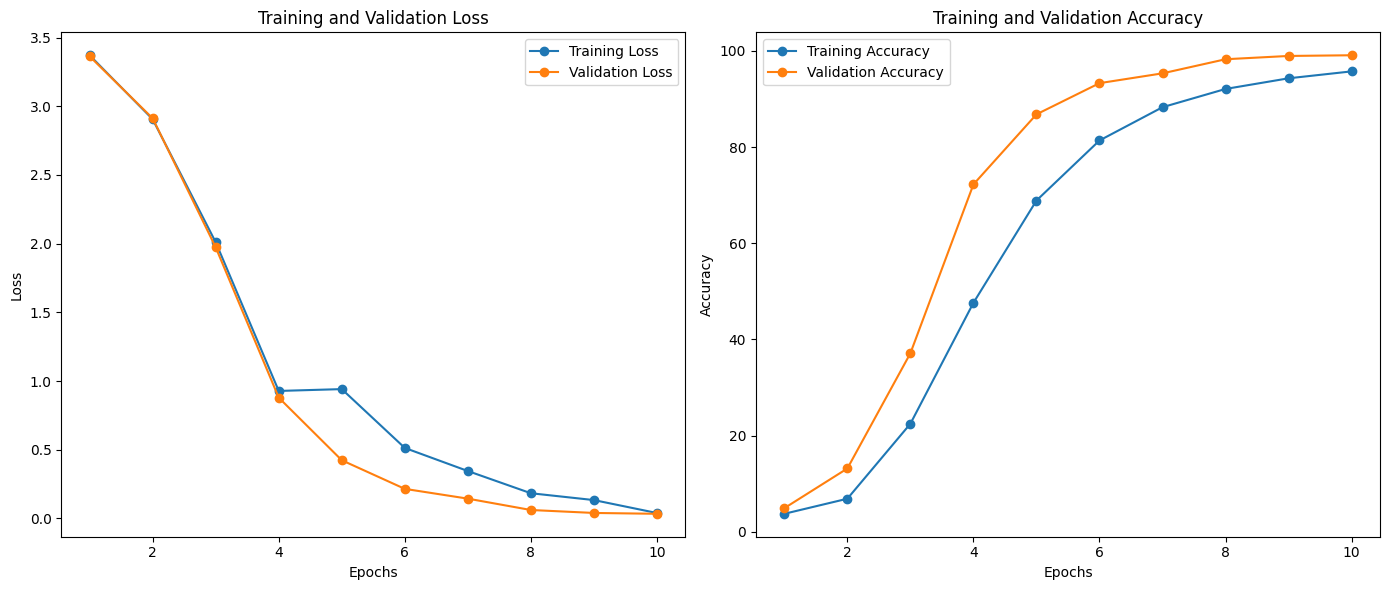

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(range(1,num_epochs+1), all_loss, label='Training Loss', marker='o')
ax1.plot(range(1,num_epochs+1), all_val_loss, label='Validation Loss', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1,num_epochs+1), all_acc, label='Training Accuracy', marker='o')
ax2.plot(range(1,num_epochs+1), all_val_acc, label='Validation Accuracy', marker='o')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()


plt.tight_layout()
plt.show()


After training for 10 epochs in batches of 64, the model reaches an accuracy of 95.7% on the training set, and 99.3% on the validation set. From the graphs, we see that the two sets do not intersect towards the end of training, indicating that the model is (hopefully) not overfitted. Interestingly, In the loss graph we see training loss stagnate for an epoch before rapidly decreasing to reach validation loss. This could indicate that the model fell briefly into a local minima, but than managed to exit it and converge on a better solution.

In [17]:
# Save first model outputs:

torch.save(model.state_dict(), "model1.pth")

We first create some functions to aid with model assessment:

In [29]:
from tqdm import tqdm

def evaluate_model(model, test_data, device):
    """
    Evaluates a pytorch model on a test dataset

    Args:
        model: Trained pytorch model
        test_data: A dataset generated by pytorch's Dataloader class
        device: Device to run the model on (cpu or cuda)
    
    Returns:
        all_labels: Numpy array of all ground truth values
        all_preds: Numpy array of all predicted values
    """
    model.eval()
    time_per_batch = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_data):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            pred = torch.argmax(output, dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)
            
def calculate_confusion_matrix(predictions, labels, num_classes):
    """
    Generates a confusion matrix from predicted labels and ground truth labels

    Args:
        predictions: Numpy array of predicted labels
        labels: Numpy array of ground truth labels
        num_classes: The number of classes the model can output

    Returns:
        confusion_matrix: List of lists containing FP, TP, FN, TN values for each class 
    """
     # Initialize the confusion matrix with zeros
     confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]

     # Populate the confusion matrix
     for pred, true in zip(predictions, labels):
         confusion_matrix[true][pred] += 1

     return confusion_matrix


The model is now assessed and a confusion matrix generated:

100%|██████████| 136/136 [00:09<00:00, 14.32it/s]


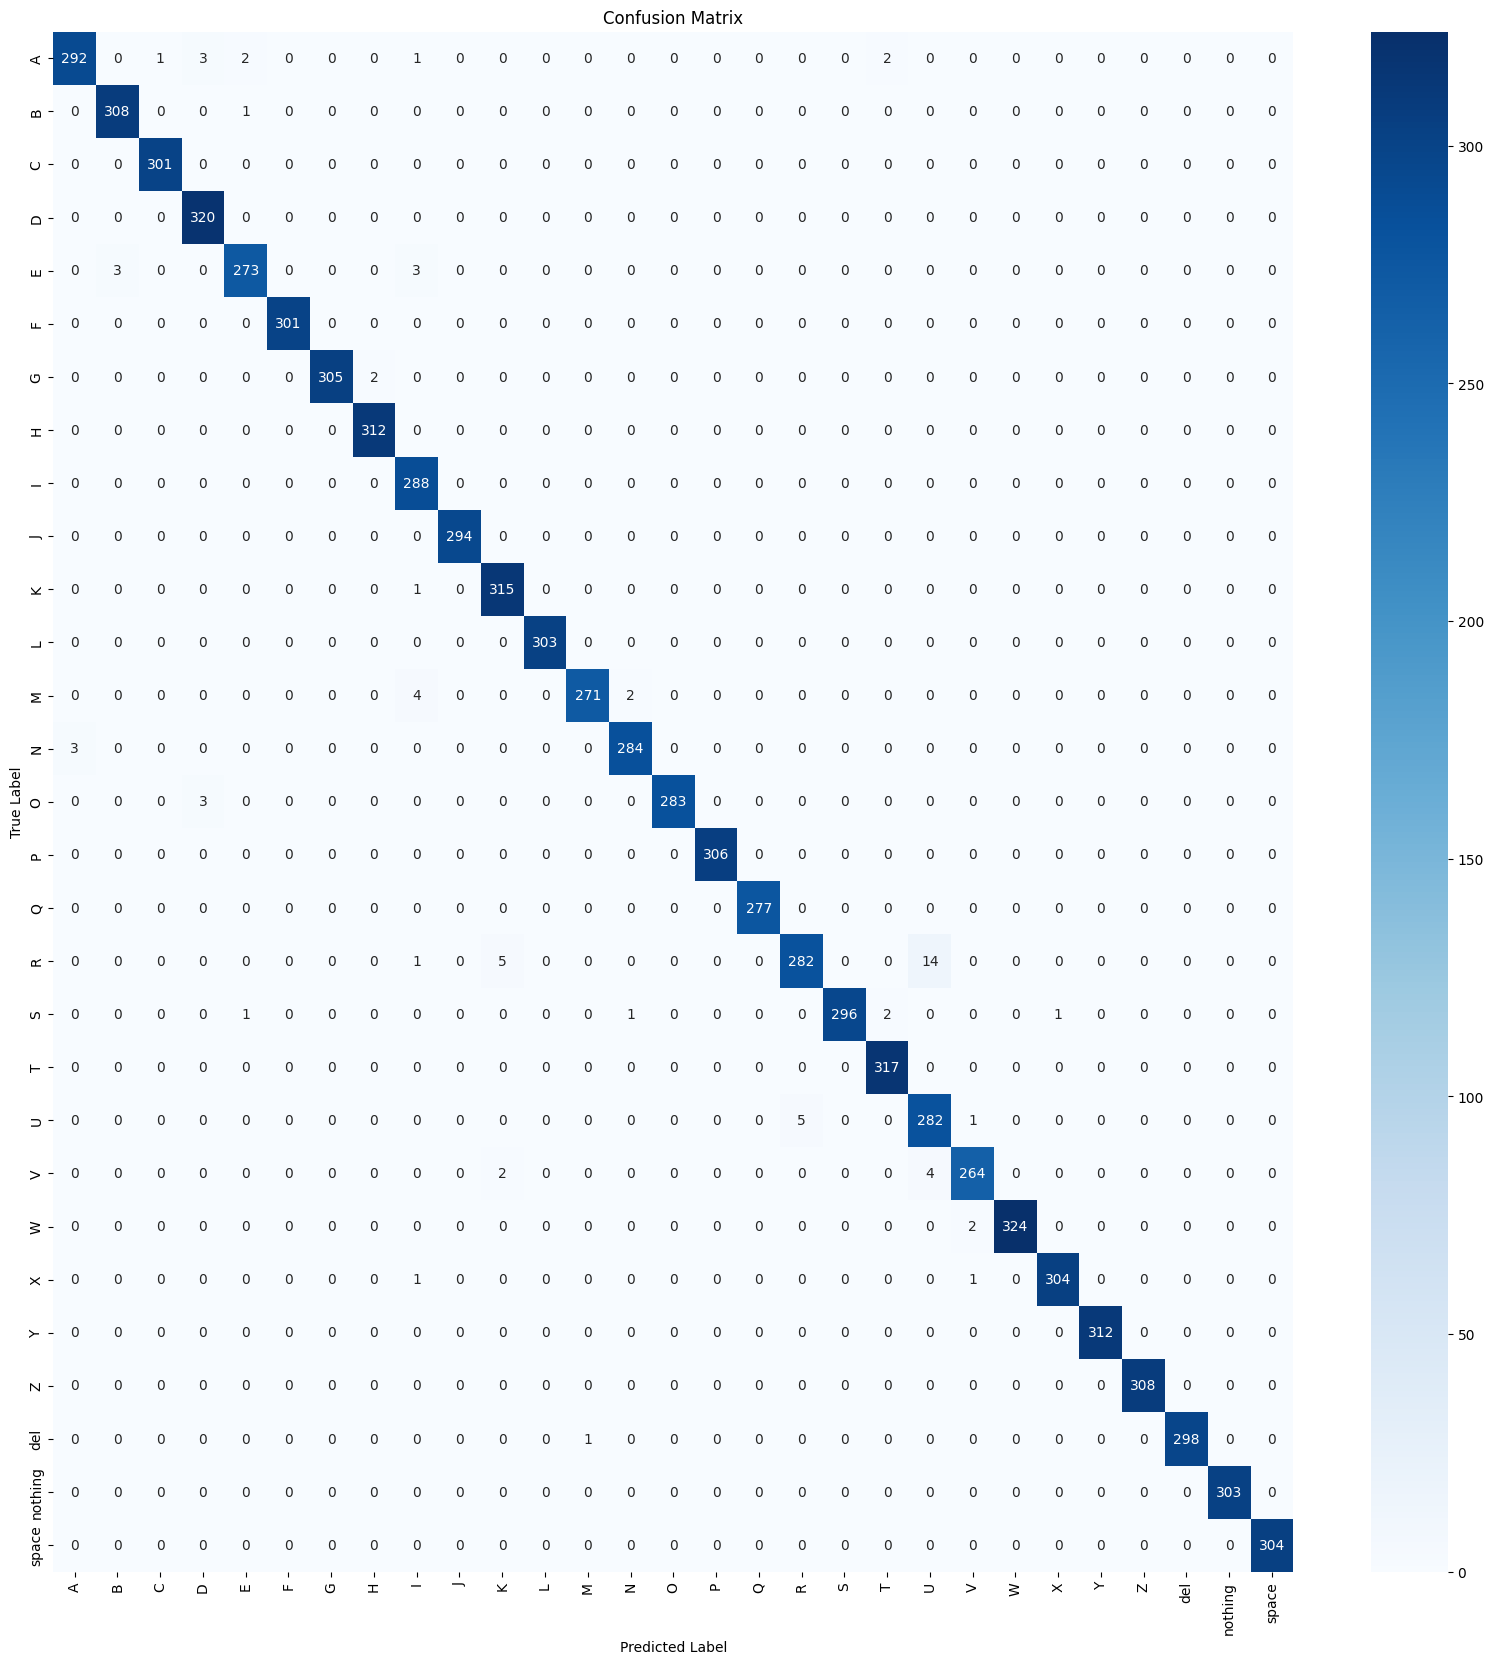

In [30]:

import seaborn as sns
labels, preds = evaluate_model(model, test_loader, device)

cm = calculate_confusion_matrix(preds, labels, len(idx_to_class.values()))
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Before analyzing the confusion matrix, I'll briefly note the performance of the model. Using the `tqdm` package to measure how long each test loop takes to evaluate, we see an average of 14.32 iterations per second of batches of 64 images. This equates to about 916 images being processed per second, which is already pretty solid performance. However, since the 64 images are being evaluated in parallel per batch, this measurement doesn't mean that the model would actually process 916 images per second if they were being provided purely sequentially. Regardless, I'll be using this metric for the upcoming model iterations ot evaluate inference time.

Back to the confusion matrix, overall, the model is looking pretty solid, with a significant majority of predictions being made correctly. Out of all the possible incorrect predictions, only one occurred more than 5 times. In the instance where it did occur, we see 14 cases of a "U" being miss-classified as an "R". Interestingly, the inverse only happened 5 times. If we plot the two signs below, we see that they are in fact quite similar:

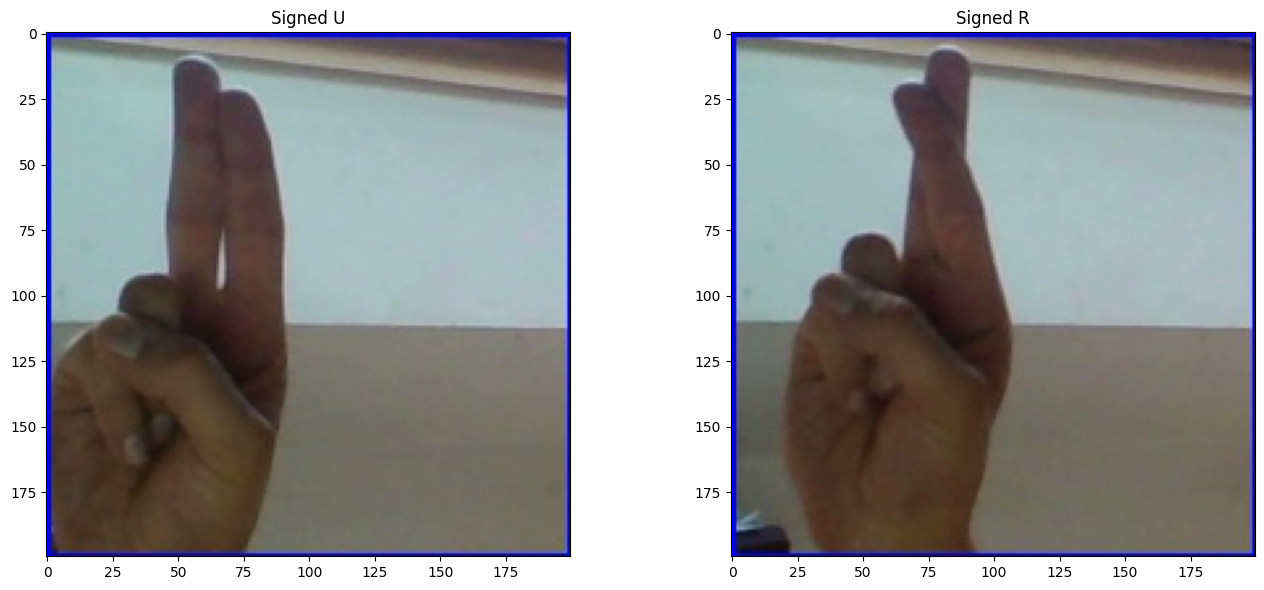

In [35]:
img_U = plt.imread('data/asl_alphabet_test/asl_alphabet_test/U_test.jpg')
img_R = plt.imread('data/asl_alphabet_test/asl_alphabet_test/R_test.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.imshow(img_U)
ax1.set_title('Signed U')

ax2.imshow(img_R)
ax2.set_title('Signed R')

plt.tight_layout()
plt.show()

Besides the fingers being crossed with R, the two signs are identical. In the real world, depending on slight differences in how individuals sign "R" or "U", there are decent odds of these two being confused. While getting more data on these two signs could potentially alleviate miss-classification between the two, the actual percentage of U's classified as R's is only 4.89% of the total "U" images. All things considered, this is a miss-classification rate I'm willing to accept. In an actual transcription application, I would probably incorporate some kind of contextual spellcheck to determine the correct sign in conjunction with the model, as U/R are a vowel/consonant, and therefore serve a pretty different role in English.

# Second Model Iteration

For my second iteration of the model, I'd like to see if I can reduce the overall number of parameters in the model, while still retaining a similar accuracy to the first iteration. My reason for doing this is firstly, to reduce overall training time (first iteration took 30-50 minutes for 10 epochs), and to improve inference speed. Since the majority of my parameters are in the linear layers, and I'm hesitant to reduce the depth of the convolutional layers, I'll be aiming to scale down my model's linear layers. The new architecture is below:

In [37]:
class DexNetV2(nn.Module):
    def __init__(self, num_inputs):
        super().__init__()
        # Setup Convolutional Layers
        self.feature = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.neural = nn.Sequential(
            nn.Linear(256*num_inputs, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.Dropout(p=0.5),
            nn.Linear(64, 29)
        )
    
    def forward(self, x):
        out = self.feature(x)
        out = out.view(out.size(0), -1)
        out = self.neural(out)
        return out

In [ ]:
model_sum = DexNetV2(num_inputs=64).to(device)
summary(model_sum, (3,200,200))

"""
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 256, 8, 8]           --
|    └─Conv2d: 2-1                       [-1, 96, 49, 49]          34,944
|    └─ReLU: 2-2                         [-1, 96, 49, 49]          --
|    └─MaxPool2d: 2-3                    [-1, 96, 24, 24]          --
|    └─Conv2d: 2-4                       [-1, 256, 24, 24]         614,656
|    └─ReLU: 2-5                         [-1, 256, 24, 24]         --
|    └─MaxPool2d: 2-6                    [-1, 256, 11, 11]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         885,120
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 384, 15, 15]         1,327,488
|    └─ReLU: 2-10                        [-1, 384, 15, 15]         --
|    └─Conv2d: 2-11                      [-1, 256, 17, 17]         884,992
|    └─ReLU: 2-12                        [-1, 256, 17, 17]         --
|    └─MaxPool2d: 2-13                   [-1, 256, 8, 8]           --
├─Sequential: 1-2                        [-1, 29]                  --
|    └─Linear: 2-14                      [-1, 128]                 2,097,280
|    └─ReLU: 2-15                        [-1, 128]                 --
|    └─Dropout: 2-16                     [-1, 128]                 --
|    └─Linear: 2-17                      [-1, 64]                  8,256
|    └─Dropout: 2-18                     [-1, 64]                  --
|    └─Linear: 2-19                      [-1, 29]                  1,885
==========================================================================================
Total params: 5,854,621
Trainable params: 5,854,621
Non-trainable params: 0
Total mult-adds (G): 1.15
==========================================================================================
Input size (MB): 0.46
Forward/backward pass size (MB): 4.60
Params size (MB): 22.33
Estimated Total Size (MB): 27.40
==========================================================================================
"""

### Linear Section:

The linear layers are the only one's changed from the first iteration. With quite a substantial reduction in the number of neurons per layer, the total number of model parameters has been decreased from 12 million down to 5.8 million. Assuming model performance holds up, this should ideally reduce training time, while improving inference speed.

In [44]:
modelV2 = DexNetV2(num_inputs=64).to(device)

loss_func = nn.CrossEntropyLoss()

lr = 0.008

optimizer = torch.optim.SGD(modelV2.parameters(), lr=lr)

In [55]:
num_epochs = 10
all_loss = []
all_acc = []
all_val_loss = []
all_val_acc = []

for epoch in range(num_epochs): # Iterate through training for the specified number of epochs.
    modelV2.train()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader): # Evaluate each batch, update loss, and backpropogate the results.

        images = images.to(device)
        labels = labels.to(device)

        output = modelV2(images)
        loss = loss_func(output, labels)
        total += labels.size(0)
        pred = torch.argmax(output, dim=1)
        correct += (pred == labels).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    all_loss.append(loss.item())
    all_acc.append(100 * (correct/total))

    with torch.no_grad(): # Evaluate model performance on the validation set.
        modelV2.eval()
        correct = 0
        total = 0
        val_loss = []
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = modelV2(images)
            total += labels.size(0)
            pred = torch.argmax(output, dim=1)
            correct += (pred == labels).sum().item()
            val_loss.append(loss_func(output, labels).item())
        
        mean_val_loss = sum(val_loss) / len(val_loss)
        mean_val_acc = 100 * (correct/total)
        all_val_loss.append(mean_val_loss)
        all_val_acc.append(mean_val_acc)

    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

Epoch [1/1], Loss: 0.1599, Val-loss: 0.0349, Val-acc: 99.1%


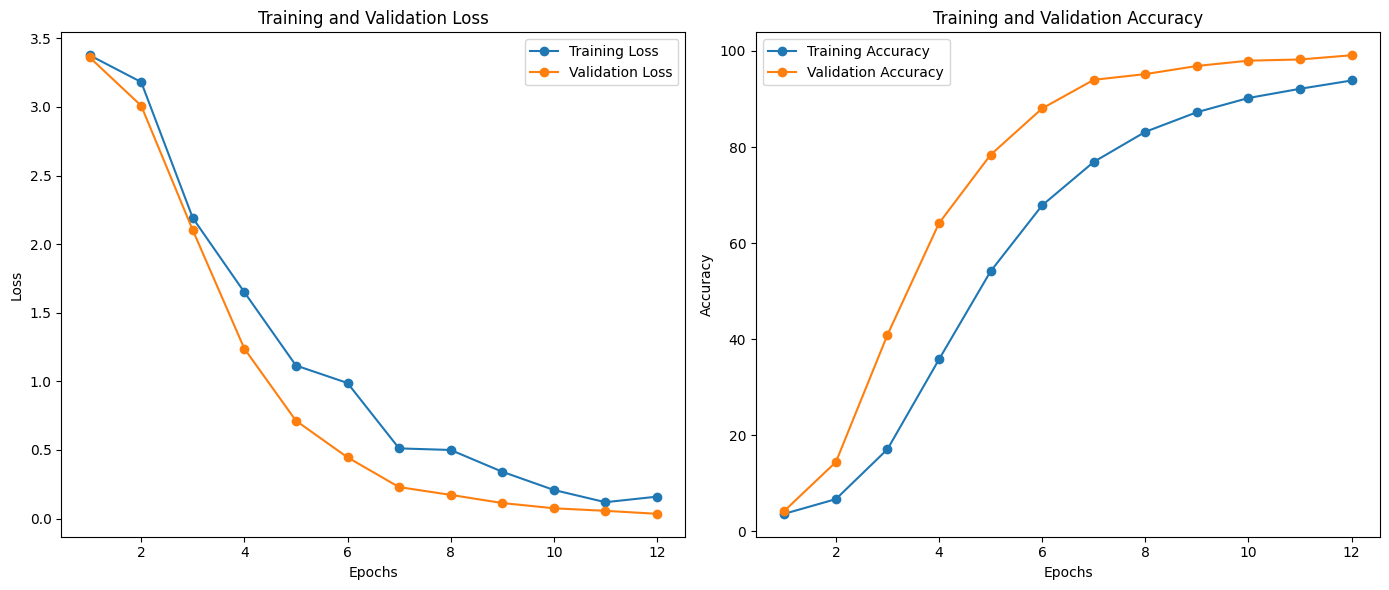

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(range(1,13), all_loss, label='Training Loss', marker='o')
ax1.plot(range(1,13), all_val_loss, label='Validation Loss', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1,13), all_acc, label='Training Accuracy', marker='o')
ax2.plot(range(1,13), all_val_acc, label='Validation Accuracy', marker='o')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()


plt.tight_layout()
plt.show()


Compared to the model's first iteration, this version took a similar amount of time to train per-epoch, but required more epochs to get close to the accuracy of the first model. Despite the increased training time required, I think it's still a good outcome, since the model has "mostly" similar training/validation accuracy, while having less than half the parameters of the first model. After training for 12 epochs, this model has a 93.85% training accuracy, compared to the first model with a 95.72% training accuracy.

In [59]:
# Save second model outputs:

torch.save(model.state_dict(), "model2.pth")

Generate the confusion matrix:

100%|██████████| 136/136 [00:09<00:00, 14.83it/s]


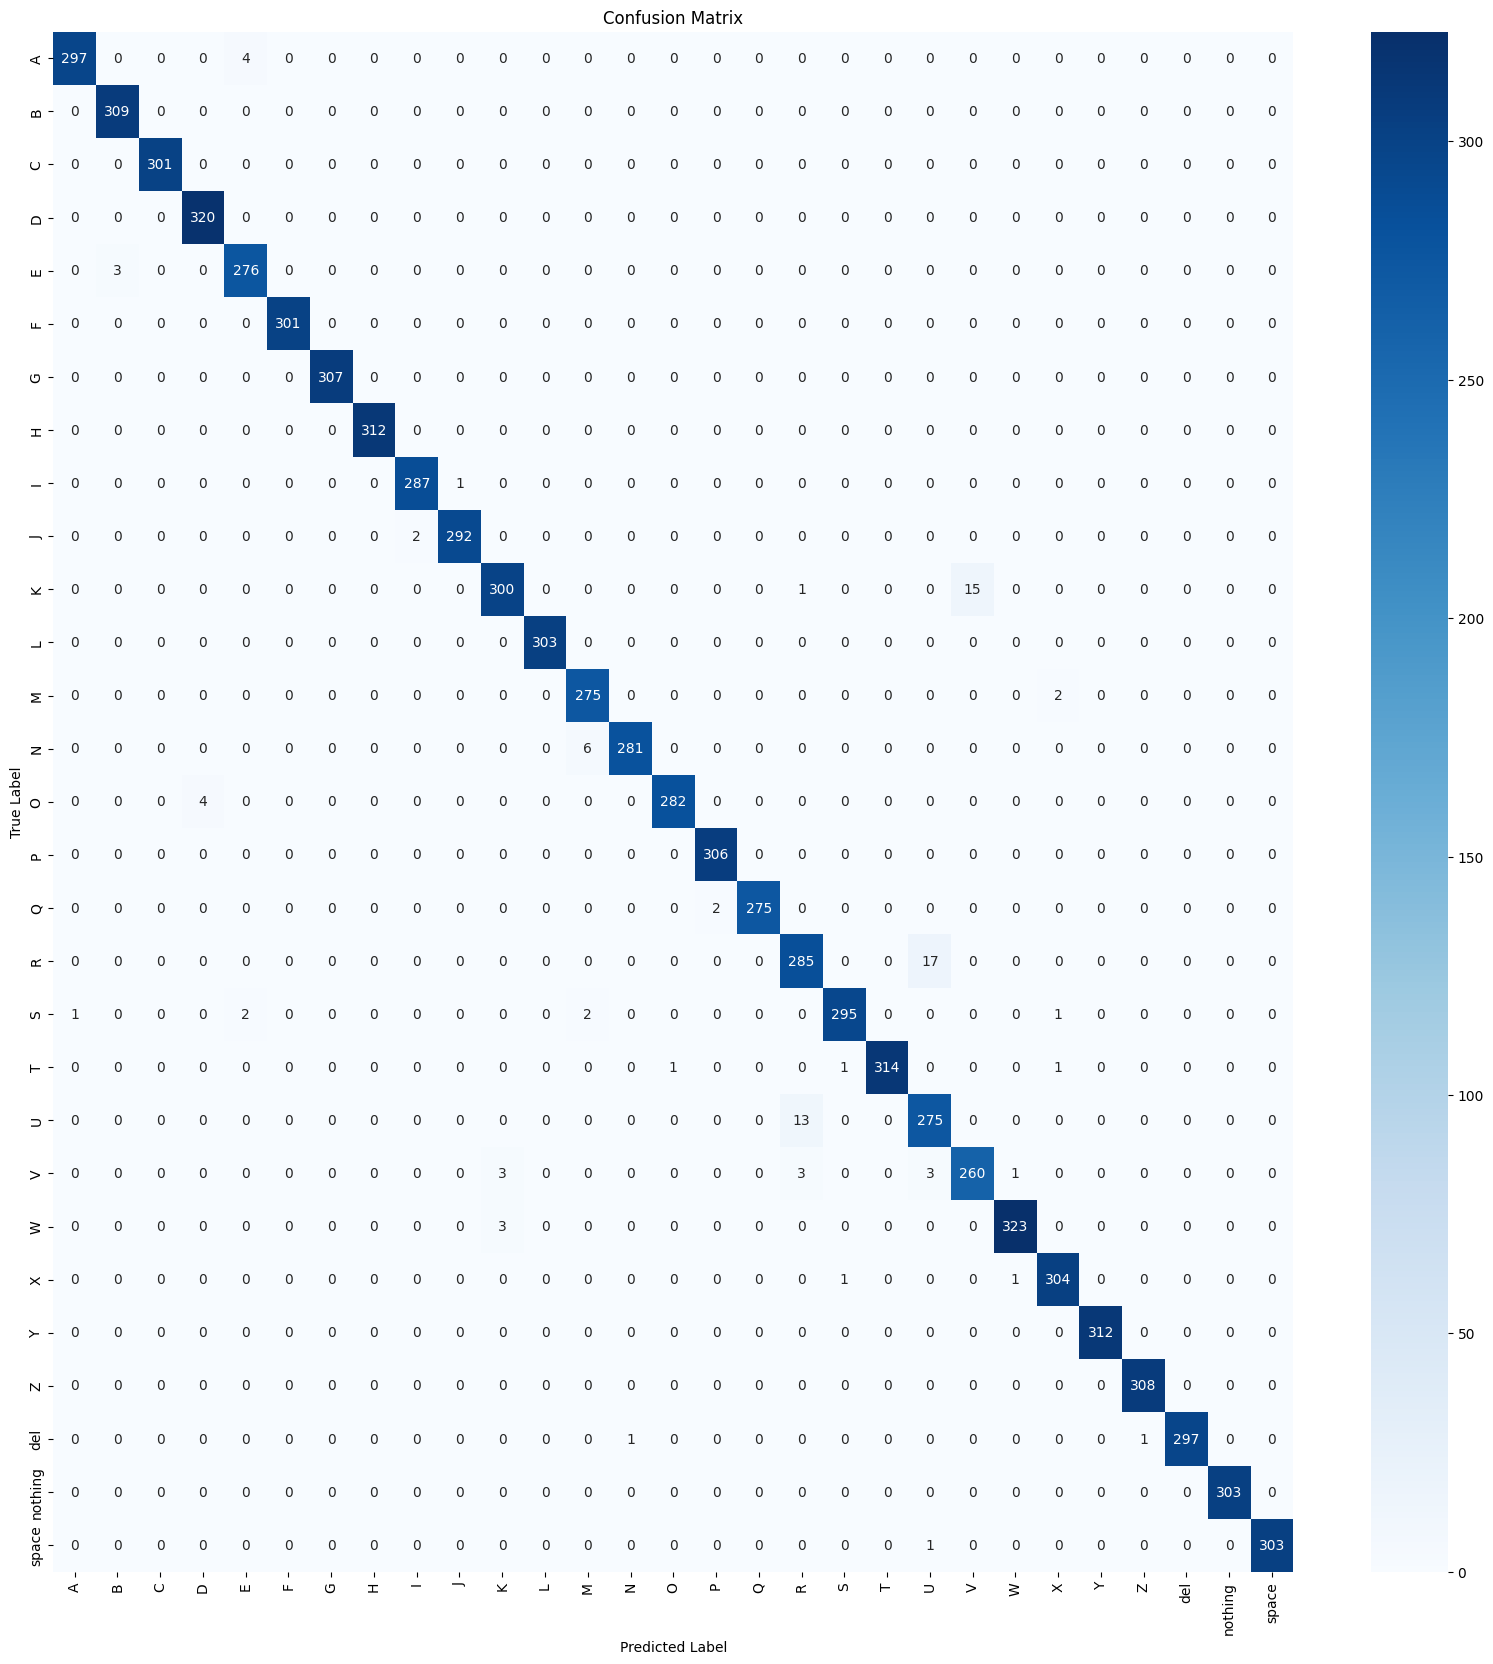

In [60]:
labels, preds = evaluate_model(modelV2, test_loader, device)

cm = calculate_confusion_matrix(preds, labels, len(idx_to_class.values()))
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Iteration two of the model processes 14.83 iterations per second during the test loop, which equates to around 949 images per second. Compared to the first model, this one processes 33 more images, an improvement of about 3.6%. While this is a very slight improvement, we can see above that this has come at the cost of model accuracy. Additionally, this improvement is most likely just due to slight variance in model inference time on a run-by-run basis.

Using the previous metric of miss-classifications that have occurred more than 5 times, we see 2 new cases of this occurring. For one, we see a return of the famous "R" vs. "U" sign classification. In this iteration, we see U's being miss-classified as R's at a similar rate to the inverse, where in the first model it was mostly R's being miss-classified as U's, but not the inverse. we are also now seeing K's being miss-classified as V's. The opposite does not occur at any notable frequency, with only 3 out of 270 images. Comparing "V" and "K":

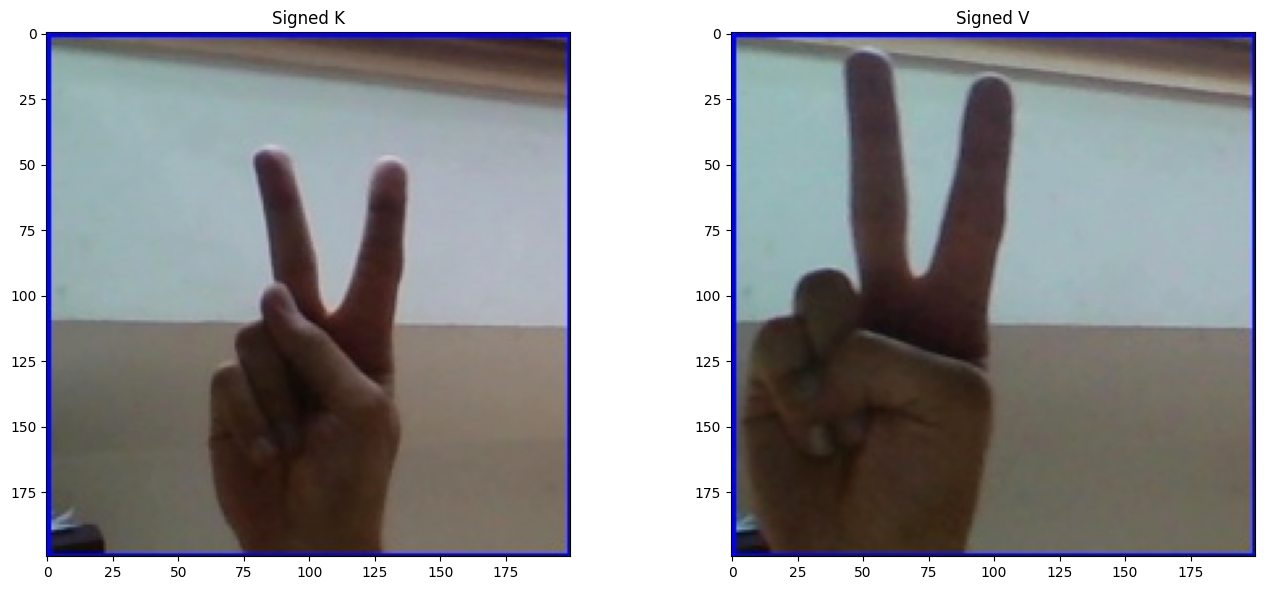

In [62]:
img_K = plt.imread('data/asl_alphabet_test/asl_alphabet_test/K_test.jpg')
img_V = plt.imread('data/asl_alphabet_test/asl_alphabet_test/V_test.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.imshow(img_K)
ax1.set_title('Signed K')

ax2.imshow(img_V)
ax2.set_title('Signed V')

plt.tight_layout()
plt.show()

We see that "K" and "V" are very similar, with only the thumb's position being the differentiating factor. To me, these two letters are even more similar than "U" and "R". Considering the large reduction in the size of the linear layers, I still think this performance is quite good, and I'm quite impressed that the model can reasonable interpret the difference in the thumb's angle. However, once again, in the real world this model should probably be coupled with some sort of contextual spell check.

# Third Model Iteration:

For the third iteration of the model, I'll be sticking with the more performant first model's architecture, but training with a reduced dataset. While the original dataset has 3,000 examples per class, these images were clearly extracted from a continuous single video per class. Due to this, many of the images are quite similar to other images with a similar index. If the model can still be performant with a reduced set of images, then this will drastically reduce training time needed to effectively iterate on the model.

In [86]:
null_dataset, train_dataset_reduce, val_dataset_reduce, test_dataset_reduce = random_split(dataset, (0.5, 0.35, 0.1, 0.05))
print(f"Length of Train Set: {len(train_dataset_reduce)}, Length of Validation Set: {len(val_dataset_reduce)}, Length of Test Set: {len(test_dataset_reduce)}")

Length of Train Set: 30449, Length of Validation Set: 8700, Length of Test Set: 4350


With this reduction in the dataset above, each class now only has 1,049 training examples instead of the 3,000 examples prior.

In [87]:
train_loader = DataLoader(dataset=train_dataset_reduce, shuffle=True, batch_size=64, drop_last=True)
val_loader = DataLoader(dataset=val_dataset_reduce, shuffle=False, batch_size=64)
test_loader = DataLoader(dataset=test_dataset_reduce, shuffle=False, batch_size=64)

dataloaders = {
    "train": train_loader,
    "validation": val_loader,
    "test": test_loader
}

Set up training parameters for the model:

In [88]:
modelV3 = DexNet(num_inputs=64).to(device)

loss_func = nn.CrossEntropyLoss()

lr = 0.008

optimizer = torch.optim.SGD(modelV3.parameters(), lr=lr)

Train the model:

In [99]:
num_epochs = 1
all_loss = []
all_acc = []
all_val_loss = []
all_val_acc = []
for epoch in range(num_epochs): # Iterate through training for the specified number of epochs.
    modelV3.train()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader): # Evaluate each batch, update loss, and backpropagate the results.

        images = images.to(device)
        labels = labels.to(device)

        output = modelV3(images)
        loss = loss_func(output, labels)
        total += labels.size(0)
        pred = torch.argmax(output, dim=1)
        correct += (pred == labels).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    all_loss.append(loss.item())
    all_acc.append(100 * (correct/total))

    with torch.no_grad(): # Evaluate model performance on the validation set.
        modelV3.eval()
        correct = 0
        total = 0
        val_loss = []
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = modelV3(images)
            total += labels.size(0)
            pred = torch.argmax(output, dim=1)
            correct += (pred == labels).sum().item()
            val_loss.append(loss_func(output, labels).item())
        
        mean_val_loss = sum(val_loss) / len(val_loss)
        mean_val_acc = 100 * (correct/total)
        all_val_loss.append(mean_val_loss)
        all_val_acc.append(mean_val_acc)

    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

Epoch [1/1], Loss: 0.1397, Val-loss: 0.0443, Val-acc: 98.9%


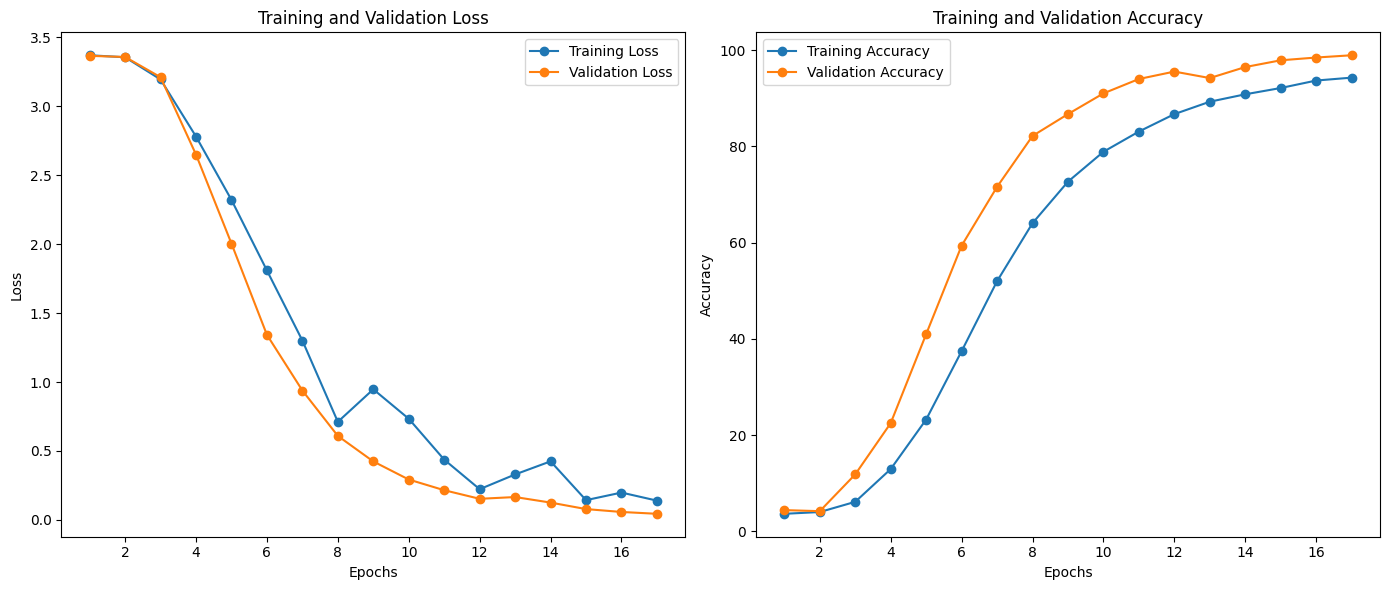

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(range(1,18), all_loss, label='Training Loss', marker='o')
ax1.plot(range(1,18), all_val_loss, label='Validation Loss', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1,18), all_acc, label='Training Accuracy', marker='o')
ax2.plot(range(1,18), all_val_acc, label='Validation Accuracy', marker='o')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()


plt.tight_layout()
plt.show()

Compared to the previous model iterations, this one was trained with just a third of the data provided to the first two. As a result, training time was about 1 minute per epoch, which is about a third the time it took for the other models per epoch. Due to this, while the model needed 17 epochs to attain comparable training/validation accuracy to the prior models, its overall training time was greatly reduced.

In [102]:
# Save third model outputs:

torch.save(model.state_dict(), "model3.pth")

Generate the confusion matrix:

100%|██████████| 68/68 [00:04<00:00, 14.67it/s]


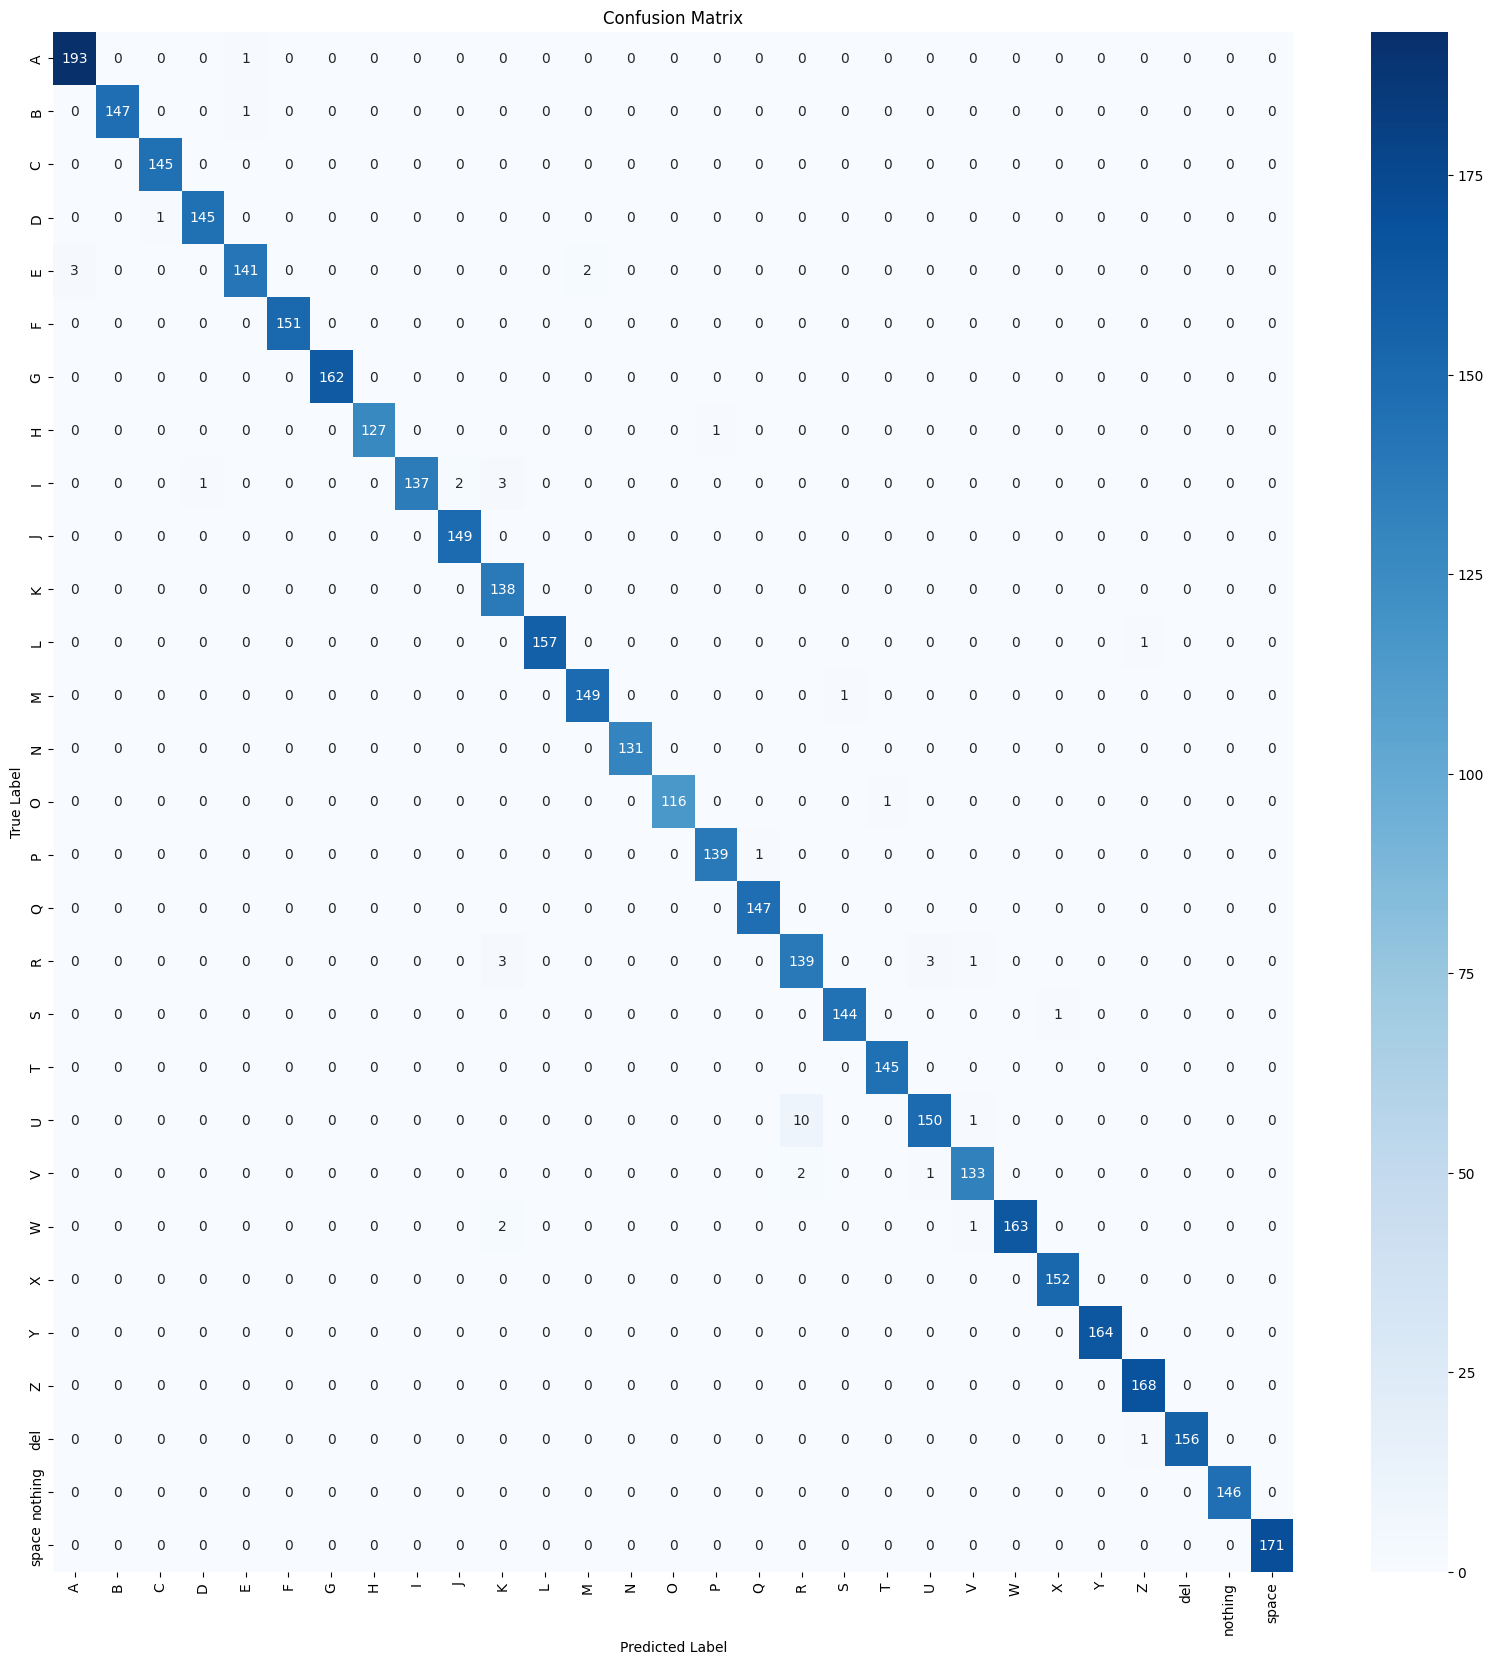

In [108]:
labels, preds = evaluate_model(modelV3, test_loader, device)

cm = calculate_confusion_matrix(preds, labels, len(idx_to_class.values()))
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Iterations per second is quite similar to the first and second model. Since the architecture is the same as the first model, there probably is just some inherent variation in inference times.

Comparing this confusion matrix to the very first one, the miss-classification frequency of "R" and "U" are essentially flipped. Since model 1 and 3 have the same architecture, this indicates to me that the issue actually goes both ways, and that there isn't necessarily a problem with U's being miss-classified more easily as R's than the inverse, but rather was just a result of the data provided during the training/test/val split.

# Reflection

Ultimately, the two variations I made to the original model are focused on time. The first variation is focused on inference time, while the second variation is focused on training time. For me, the most interesting result was the third variation. There's this idea in machine learning that you can never have too much data, but at some point, you do get serious diminishing returns in terms of model training time vs. model performance. The fact that I could use just a third of the original data, still get the same performance, but train in less than half the time shows this. If I was developing this model further for use in the real world, I would for sure use the third iteration for the majority of my future testing and iteration, including methodologies such as systematic hyperparameter tuning.

However, as I brought up towards the beginning of the notebook, this model is inherently limited by only having knowledge of a small fraction of ASL's total lexicon. While an ASL signer could spell out every word letter-by-letter, it's far too slow to be useful in most real world contexts. I'd imagine one would have to partner with some sort of ASL-focused organization to get the training data needed for an effective model, but doing so would require a model that can ID significantly more classes, with inputs that takes up significantly more data. Regardless, it is still a problem worth considering, as a model that functions well could be a boon for accessibility.